In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Performing Basic Visualizations

Visualizations on Original Data

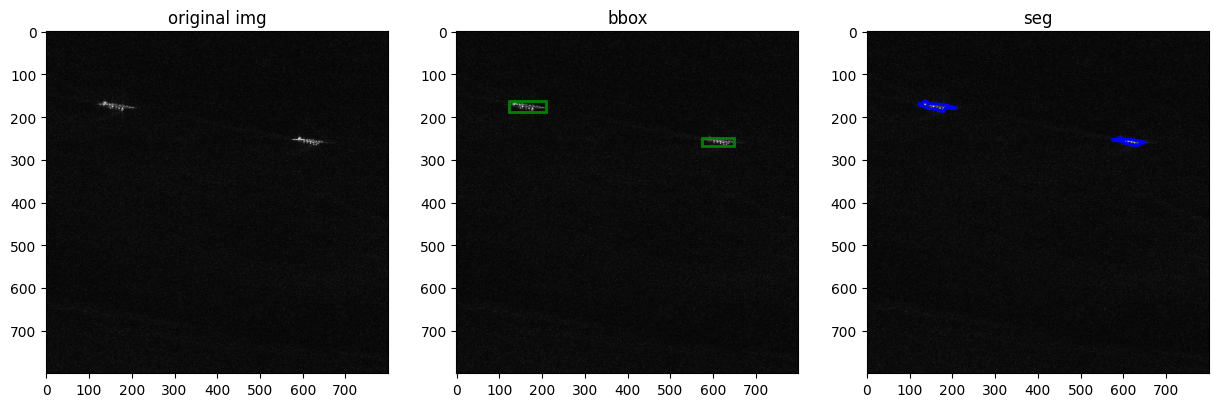

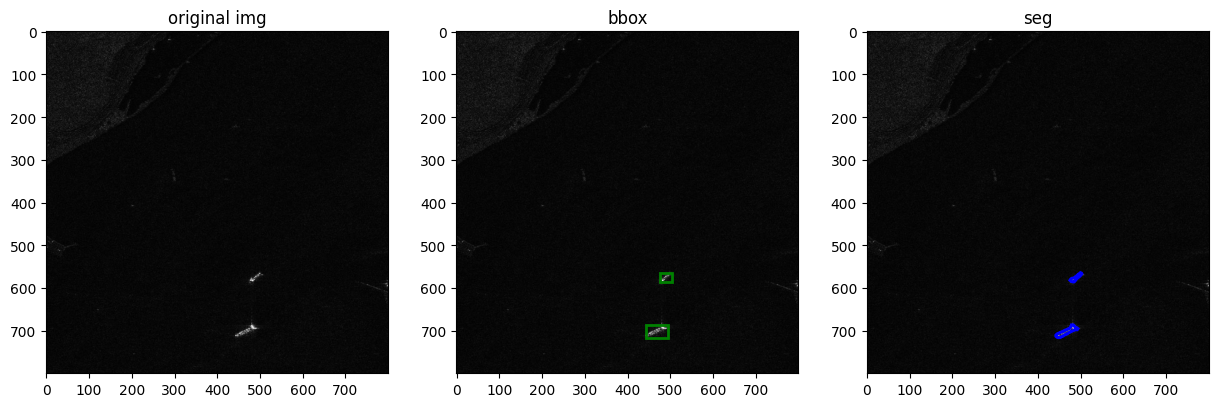

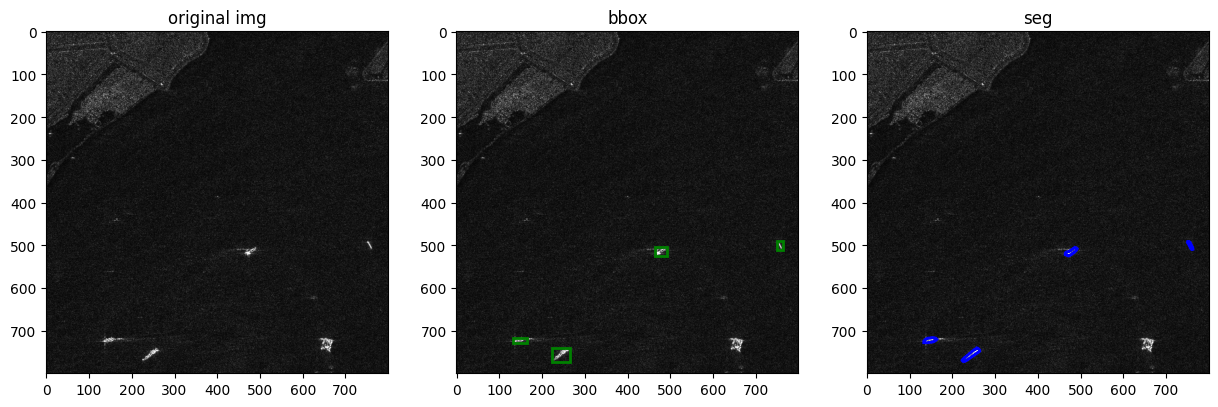

In [4]:
import json
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from matplotlib.path import Path

#function to load annotations -> train2017
def load(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

#function to perform visualizations using images folder and train2017
def visuals(images_folder, annotations, num_imgs=3):
    image_ids = random.sample(range(len(annotations['images'])), num_imgs)
    for image_id in image_ids:
        image_info = annotations['images'][image_id]
        image_path = os.path.join(images_folder, image_info['file_name'])
        image = Image.open(image_path)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for ax in axes:
            ax.imshow(image)

        for ann in annotations['annotations']:
            if ann['image_id'] == image_info['id']:
                bbox = ann['bbox']
                segmentation = ann['segmentation'][0]

                #drawing the bboxes
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none')
                axes[1].add_patch(rect)

                #drawing the segmentations
                vertices = list(zip(segmentation[::2], segmentation[1::2]))
                codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
                path = Path(vertices, codes)
                patch = patches.PathPatch(path, facecolor='none', edgecolor='b', lw=2)
                axes[2].add_patch(patch)

        axes[0].set_title('original img')
        axes[1].set_title('bbox')
        axes[2].set_title('seg')

        plt.show()


annotations_path = 'annotations/train2017.json'
images_folder = 'Images'

#loading annotations
annotations = load(annotations_path)

#get the visualizations of any 3 imgs
visuals(images_folder, annotations, num_imgs=3)

Visualizations on COCO -> YOLO converted format

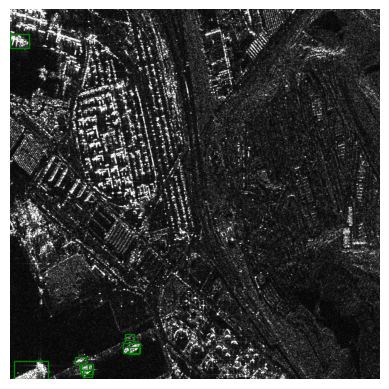

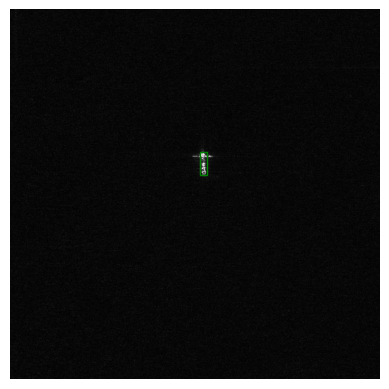

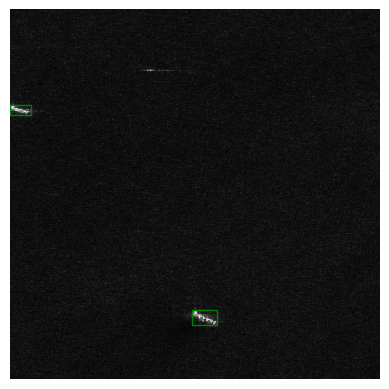

In [9]:
import os
import cv2
import random
import matplotlib.pyplot as plt

train_images_folder = "./train/images"
train_annotations_folder = "./train/labels"

images = os.listdir(train_images_folder)

#any 3 random imgs
random_images = random.sample(images, 3)

def visualize_image_with_annotation(image_name, images_folder, annotations_folder):
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    #read corresponding annotation
    annotation_name = image_name.replace(".jpg", ".txt")
    annotation_path = os.path.join(annotations_folder, annotation_name)
    
    with open(annotation_path, 'r') as file:
        annotations = file.readlines()
    
    fig, ax = plt.subplots(1)
    
    ax.imshow(image_rgb)
    
    for annotation in annotations:
        annotation = annotation.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, annotation)
        
        #normalized coordinates -> absolute pixel values
        x_min = int((x_center - (box_width / 2)) * width)
        y_min = int((y_center - (box_height / 2)) * height)
        x_max = int((x_center + (box_width / 2)) * width)
        y_max = int((y_center + (box_height / 2)) * height)
        
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

#get 3 random imgs
for image_name in random_images:
    visualize_image_with_annotation(image_name, train_images_folder, train_annotations_folder)

# Splitting the data into train-test-val partitions

In [5]:
import os
import shutil
import random

#get org paths
source_images_folder = "./Images"
source_annotations_folder = "./yolo_annotations"
train_folder = "./train"
test_folder = "./test"
val_folder = "./val"

#make folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(os.path.join(train_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "annotations"), exist_ok=True)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(os.path.join(test_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "annotations"), exist_ok=True)

os.makedirs(val_folder, exist_ok=True)
os.makedirs(os.path.join(val_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "annotations"), exist_ok=True)

#ratios for splitting
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

#list imgs
images = os.listdir(source_images_folder)
random.shuffle(images)

num_images = len(images)
train_split_idx = int(num_images * train_ratio)
test_split_idx = int(num_images * (train_ratio + test_ratio))

#splitting
train_images = images[:train_split_idx]
test_images = images[train_split_idx:test_split_idx]
val_images = images[test_split_idx:]

#copying the imgs and annotations
def copy_files(image_list, source_images_folder, source_annotations_folder, dest_image_folder, dest_annotation_folder):
    for image in image_list:
        shutil.copy(os.path.join(source_images_folder, image), os.path.join(dest_image_folder, image))
        annotation_file = image.replace(".jpg", ".txt")
        shutil.copy(os.path.join(source_annotations_folder, annotation_file), os.path.join(dest_annotation_folder, annotation_file))

#train
copy_files(train_images, source_images_folder, source_annotations_folder, os.path.join(train_folder, "images"), os.path.join(train_folder, "annotations"))

#test
copy_files(test_images, source_images_folder, source_annotations_folder, os.path.join(test_folder, "images"), os.path.join(test_folder, "annotations"))

#val
copy_files(val_images, source_images_folder, source_annotations_folder, os.path.join(val_folder, "images"), os.path.join(val_folder, "annotations"))